In [1]:
!git clone https://github.com/justarationalist/ML_utils.git
import sys
sys.path.append('/content/ML_utils/utils')

Cloning into 'ML_utils'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 101 (delta 47), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 37.38 KiB | 4.15 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
from ML_utils.utils import decay_rate, print_weight_counts, print_weight_counts, DataTracker, EarlyStopping, GraphPlot, supervised_trainig_loop

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

LR = 0.03
TESTING_RATE = 5#1 test example between how many training examples
NUM_CLASSES = 10
IN_CHANNELS = 1
TRAIN_SIZE = 60000
TEST_SIZE = 10000
TRAIN_BATCH_SIZE = 60
TEST_BATCH_SIZE = 50
TRAIN_BATCH_COUNT = TRAIN_SIZE // TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = TRAIN_BATCH_COUNT // TESTING_RATE

EMA_RATE1 = lambda s: decay_rate(4/s, s)
EMA_RATE2 = lambda s: decay_rate(0.4, s)

EARLY_STOPPING_DR = EMA_RATE1(TEST_BATCH_COUNT)
EARLY_STOPPING_DERIVATIVE_DR = EMA_RATE2(TEST_BATCH_COUNT)
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_BAR = -0.0013
EARLY_STOPPING_GRACE_PERIOD = TEST_BATCH_COUNT/4


dataset = torchvision.datasets.MNIST

trainset = dataset(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testset = dataset(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]


In [4]:
class Arch(nn.Module):
    def __init__(self):
        super(Arch, self).__init__()
        self.conv1_dim = 2
        self.conv2_dim = 3
        self.reduced_size = (3,3)
        self.reduced_area = self.reduced_size[0] * self.reduced_size[1]

        self.conv1 = nn.Conv2d(IN_CHANNELS, self.conv1_dim, kernel_size=5, stride=1, padding=0)#24x24
        self.activ = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)#12x12
        self.conv2 = nn.Conv2d(self.conv1_dim, self.conv2_dim, kernel_size=3, stride=1, padding=1)#12x12
        self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=4)#3x3
        self.fc = nn.Linear(self.reduced_area * self.conv2_dim, NUM_CLASSES)
        self.bn1 = nn.BatchNorm2d(self.conv1_dim)
        self.bn2 = nn.BatchNorm2d(self.conv2_dim)
        self.bn3 = nn.BatchNorm1d(NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activ(x)
        x = self.maxpool2(x)

        x = x.view(-1, self.reduced_area * self.conv2_dim)
        x = self.fc(x)
        x = self.bn3(x)

        return x

def initialize_model():
    model = Arch().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    return model, criterion, optimizer
model, criterion, optimizer = initialize_model()

parameters {
  conv1.weight: 50,
  conv1.bias: 2,
  conv2.weight: 54,
  conv2.bias: 3,
  fc.weight: 270,
  fc.bias: 10,
  bn1.weight: 2,
  bn1.bias: 2,
  bn2.weight: 3,
  bn2.bias: 3,
  bn3.weight: 10,
  bn3.bias: 10,
}
total: 419
epoch 1 test loss 0.31758, test loss diff(ema) -0.005915, patience hits 0(+0)/10
epoch 2 test loss 0.20398, test loss diff(ema) -0.002657, patience hits 0(+0)/10
early stopping at epoch 2+86% test loss 0.18872, test loss diff(ema) -0.001230, patience hits 10(+10)/10
accuracy 94.54%


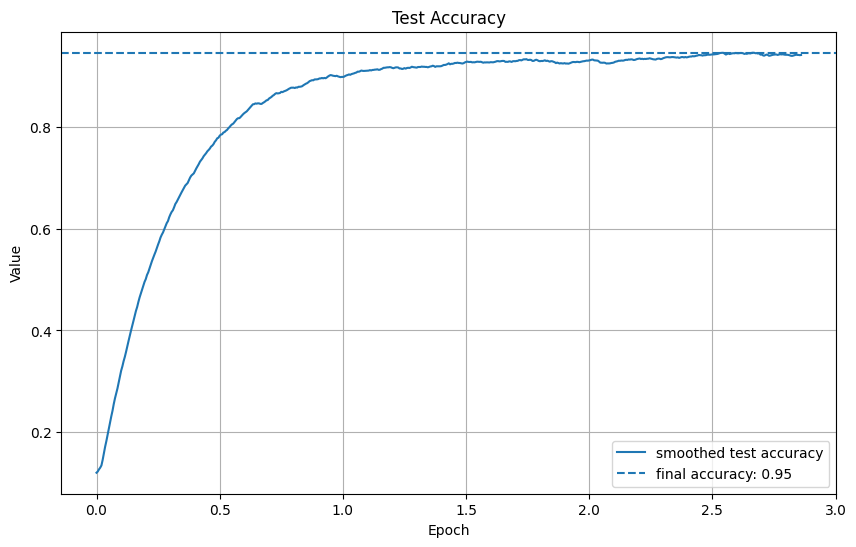

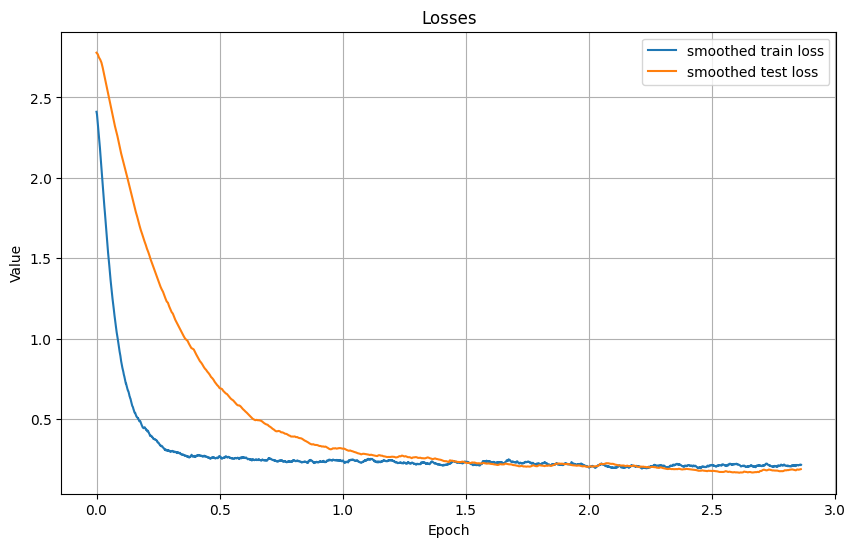

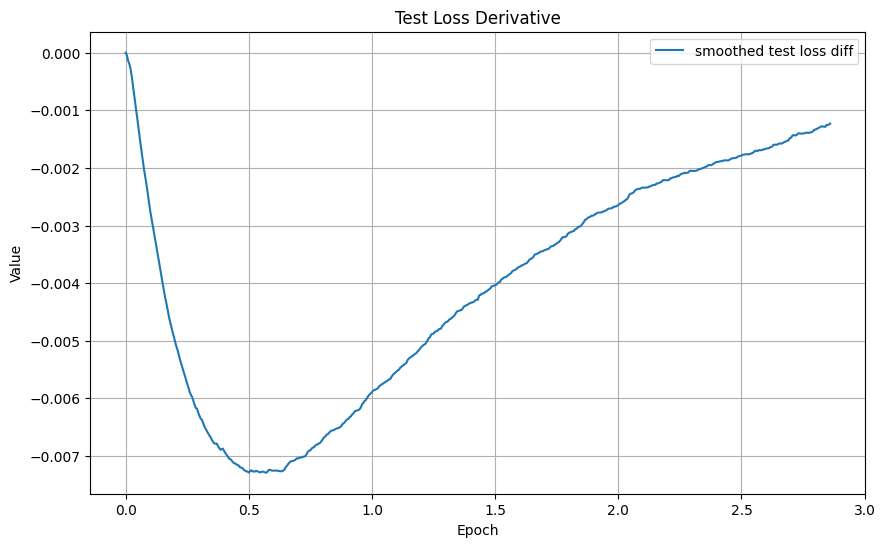

In [6]:
model, criterion, optimizer = initialize_model()

def print_progress(current_batch=-1):
    epoch = data_tracker.get_data(DataTracker.EPOCH)[0]
    last_test_loss_ema = early_stopping.last_test_loss_ema()
    last_test_loss_diff_ema = early_stopping.last_test_loss_diff_ema()
    last_patience_counter = early_stopping.last_patience_counter()
    last_patience_counter_diff = early_stopping.last_patience_counter_diff()
    msg = f"epoch {epoch:.0f} test loss {last_test_loss_ema:.5f}, test loss diff(ema) {last_test_loss_diff_ema:.6f}, patience hits {last_patience_counter:.0f}(+{last_patience_counter_diff:.0f})/{early_stopping.patience}"
    if not early_stopping.stop:
        print(msg)
    else:
        print(f"early stopping at epoch {epoch-1:.0f}+{100*current_batch/TRAIN_BATCH_COUNT:.0f}%" + msg.removeprefix(f"epoch {epoch:.0f}"))

def finish_message():
    print(f"accuracy {data_tracker.get_data(DataTracker.FINAL_ACCURACY)[0] * 100:.2f}%")

def forward(inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss, outputs

def record_final_accuracy(inputs, targets, outputs):
    return DataTracker.FINAL_ACCURACY_HELPER_DIFF, (outputs.argmax(dim=1) == targets).sum().float().item() / TEST_SIZE
def record_smoothed_test_accuracy(inputs, targets, outputs):
    return DataTracker.SMOOTHED_TEST_ACCURACY, (outputs.argmax(dim=1) == targets).float().mean()

'''
early stopping records test loss and test loss diff automatically
the supervised training loop records the train loss automatically
'''

data_tracker = DataTracker([
    DataTracker.TrackInfo(name=DataTracker.SMOOTHED_TEST_ACCURACY, ema_decay_rate=EMA_RATE1(TEST_BATCH_COUNT), save_history=True, first_record_factor=1),
    DataTracker.TrackInfo(name=DataTracker.FINAL_ACCURACY, derivative=DataTracker.TrackInfo(DataTracker.FINAL_ACCURACY_HELPER_DIFF))
])

early_stopping = EarlyStopping(test_loss_decay_rate=EARLY_STOPPING_DR, train_loss_decay_rate=EARLY_STOPPING_DERIVATIVE_DR, data_tracker=data_tracker, patience=EARLY_STOPPING_PATIENCE, stop_bar=EARLY_STOPPING_BAR, grace_peroid=EARLY_STOPPING_GRACE_PERIOD)

graph_plot = GraphPlot(data_tracker, {
    "Test Accuracy": [(DataTracker.SMOOTHED_TEST_ACCURACY, 1/TEST_BATCH_COUNT), (DataTracker.FINAL_ACCURACY, 1)],
    "Losses": [(DataTracker.SMOOTHED_TRAIN_LOSS, 1 / TRAIN_BATCH_COUNT), (DataTracker.SMOOTHED_TEST_LOSS, 1/TEST_BATCH_COUNT)],
    "Test Loss Derivative": [(DataTracker.SMOOTHED_TEST_LOSS_DIFF, 1/TEST_BATCH_COUNT)]
})

supervised_trainig_loop(
    data_tracker = data_tracker,
    early_stopping = early_stopping,
    graph_plot = graph_plot,
    models = [model],
    optimizers = [optimizer],
    trainloader = trainloader,
    testloader = testloader,
    device = device,
    forward = forward,
    TESTING_RATE = TESTING_RATE,
    print_progress = print_progress,
    finish_message = finish_message,
    print_weights = lambda : print_weight_counts(model),
    smoothed_train_loss_decay_rate = EMA_RATE1(TEST_BATCH_COUNT),
    additional_test_records = [record_smoothed_test_accuracy],
    additional_post_records = [record_final_accuracy]
)